# Estimate car price - Apply saved model

### Introduction
-  Push calculations down to SAP HANA. 
-  Leverage the in-memory performance directly out of Python without data extraction.

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Predictive Analysis Library (PAL):  
   https://help.sap.com/viewer/2cfbc5cf2bc14f028cfbe2a2bba60a50/latest/en-US/f652a8186a144e929a1ade7a3cb7abe8.html
-  Dataset: https://www.kaggle.com/bozungu/ebay-used-car-sales-data

### Create connection to SAP HANA

In [1]:
# Obtain logon details from the central Connection Management of SAP Data Intelligence
import hana_ml.dataframe as dataframe

# Instantiate connection object
from notebook_hana_connector.notebook_hana_connector import NotebookConnectionContext
conn = NotebookConnectionContext(connectionId='HANADB')

### Load model

In [2]:
import hana_ml as hana_ml
from hana_ml.algorithms.pal import trees

In [3]:
df_model_saved = hana_ml.dataframe.DataFrame(conn, 'select * from TAXX.USEDCARPRICES_MODEL_REGTREE')
tree_reg_saved = trees.DecisionTreeRegressor(conn, algorithm='cart')
tree_reg_saved.model_ = df_model_saved.select('ROW_INDEX', 'MODEL_CONTENT')

### Predict price of "new" cars

In [4]:
# Create HANA dataframe for the table that holds the data for prediction
df_pushdown_new = conn.table("USEDCARPRICES_TOPREDICT", schema="TAXX")
df_pushdown_new.head(3).collect()

,CAR_ID,VEHICLETYPE,MODEL,YEAR,GEARBOX_IMP,HP,FUELTYPE,KILOMETER,DAMAGED
0,1,coupe,CLK,2006.0,manual,231.0,petrol,50000.0,no
1,2,coupe,CLK,2006.0,manual,231.0,petrol,150000.0,no


In [5]:
# Predict the price
features = ['GEARBOX_IMP', "VEHICLETYPE", "YEAR", "MODEL", "HP", "FUELTYPE", "KILOMETER", "DAMAGED"]
df_predict = tree_reg_saved.predict(df_pushdown_new, features=features, key="CAR_ID").select("CAR_ID", "SCORE").collect()
df_predict

,CAR_ID,SCORE
0,1,16824.7
1,2,11974.6


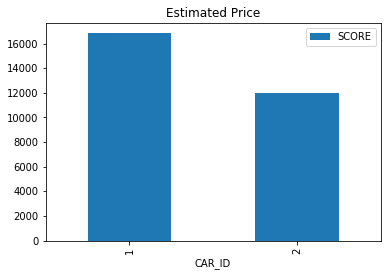

In [6]:
%matplotlib inline 
import pandas as pd
df_predict["SCORE"] = pd.to_numeric(df_predict["SCORE"])
df_predict['CAR_ID'] = df_predict['CAR_ID'].astype(str)
df_predict.plot.bar(x="CAR_ID", y="SCORE", title="Estimated Price");

In [7]:
# Predict and write to table
tree_reg_saved.predict(df_pushdown_new, features=features, key="CAR_ID").save(where=("TAXX", "USEDCARPRICES_PREDICTED"), table_type="COLUMN")

### Close connection

In [8]:
conn.close()